Usage details 使用细节

In [ ]:
%%bigquery

SELECT
  TIMESTAMP_TRUNC(jbo.creation_time, DAY) AS usage_date,
  jbo.project_id,
  jbo.job_type,
  jbo.user_email,
  jbo.job_id,
  SAFE_DIVIDE(jbo.total_slot_ms, TIMESTAMP_DIFF(jbo.end_time ,jbo.start_time, MILLISECOND)) AS num_slots
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_ORGANIZATION jbo

In [ ]:
%%bigquery

SELECT
  job.creation_time,
  job.project_id,
  job.job_type,
  job.user_email,
  job.job_id,
  job.query,
  TIMESTAMP_DIFF(job.end_time,job.start_time, MILLISECOND) AS elapsed_ms,
  SAFE_DIVIDE(job.total_slot_ms, TIMESTAMP_DIFF(job.end_time,job.start_time, MILLISECOND)) AS num_slots
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT job
WHERE
  job.query NOT LIKE '%INFORMATION_SCHEMA%'
ORDER BY
  job.creation_time DESC;

Daily slot consumption and cost 每日用量与开销

In [ ]:
%%bigquery daily_usage

SELECT
  DATE(creation_time) AS usage_date,
  SUM(total_slot_ms) / 1000 AS total_slot_seconds,
  SUM(total_slot_ms) / (1000 * 60 * 60) AS total_slot_hours,
  -- This is an estimated cost. Adjust the rate based on your pricing model.
  -- Using on-demand pricing for this example ($0.04 per slot hour)
  (SUM(total_slot_ms) / (1000 * 60 * 60)) * 0.04 AS estimated_cost_usd
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
WHERE
  creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 30 DAY) AND CURRENT_TIMESTAMP()
  AND total_slot_ms > 0
GROUP BY
  usage_date
ORDER BY
  usage_date DESC;

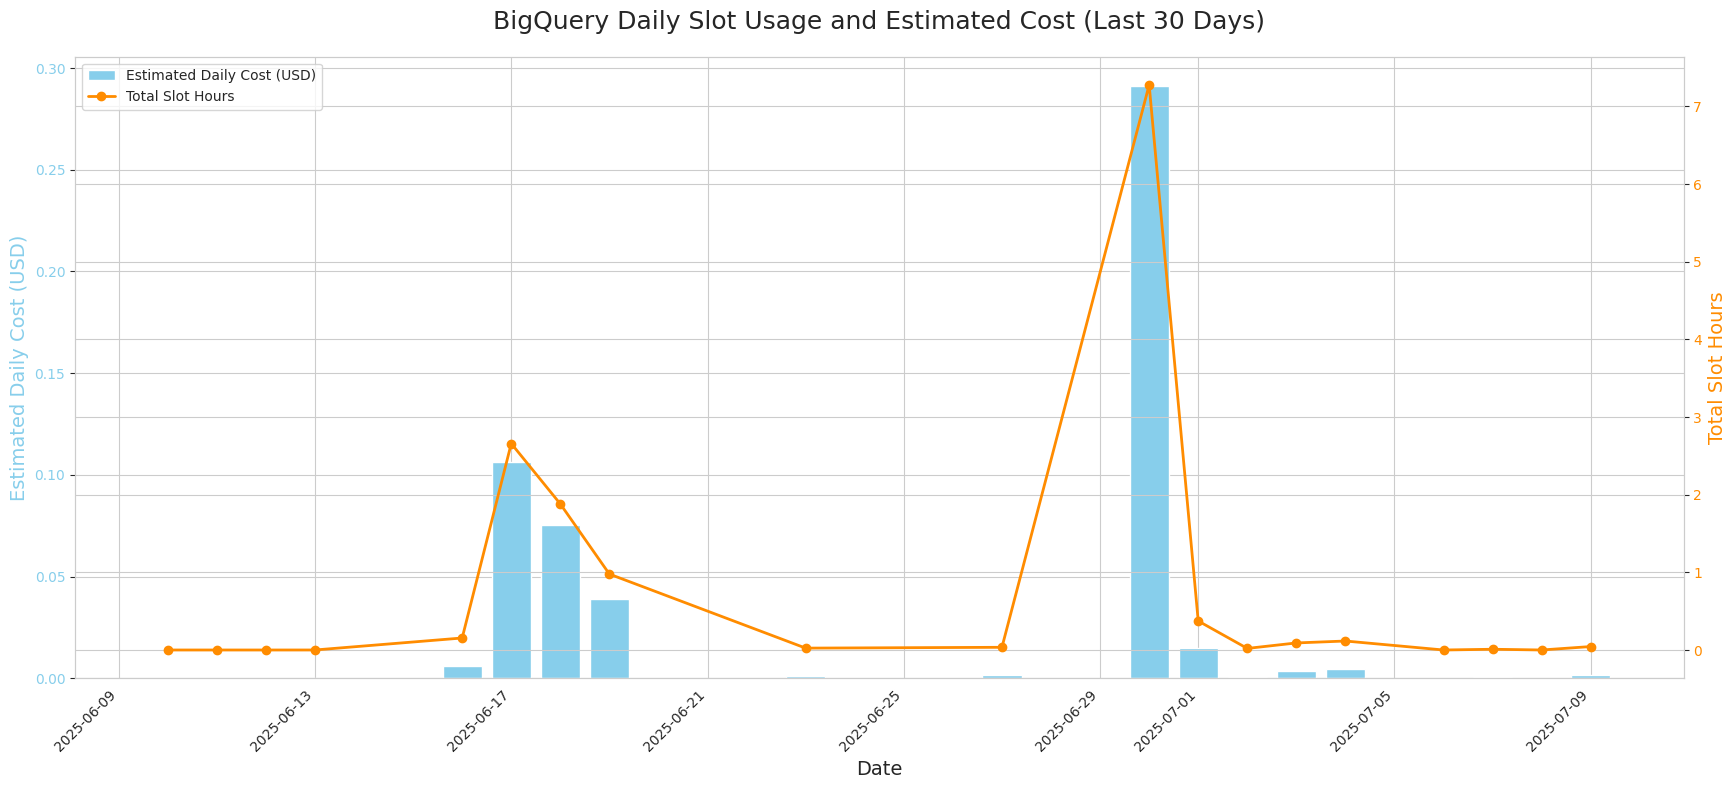

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- Plotting ---
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plot Y2: Bar chart for daily cost (ax1 - left axis)
bar_color = 'skyblue'
ax1.set_ylabel('Estimated Daily Cost (USD)', color=bar_color, fontsize=14)
ax1.bar(daily_usage['usage_date'], daily_usage['estimated_cost_usd'], color=bar_color, label='Estimated Daily Cost (USD)')
ax1.tick_params(axis='y', labelcolor=bar_color)
ax1.set_xlabel('Date', fontsize=14)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot Y1: Line chart for slot hours (ax2 - right axis)
line_color = 'darkorange'
ax2.set_ylabel('Total Slot Hours', color=line_color, fontsize=14)
ax2.plot(daily_usage['usage_date'], daily_usage['total_slot_hours'], color=line_color, marker='o', linestyle='-', linewidth=2, label='Total Slot Hours')
ax2.tick_params(axis='y', labelcolor=line_color)

# --- Formatting ---
plt.title('BigQuery Daily Slot Usage and Estimated Cost (Last 30 Days)', fontsize=18, pad=20)
fig.tight_layout(pad=3) # Adjust layout to prevent labels from overlapping

# Format x-axis to display dates nicely
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Add legends
# To combine legends from two axes, we get handles and labels from both
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

Top queries by slot consumption & distribution

槽使用分布

In [ ]:
%%bigquery

DECLARE on_demand_rate_per_slot_hour FLOAT64 DEFAULT 0.06;

SELECT
  job_id,
  user_email,
  query,
  total_slot_ms,
  creation_time,
  TIMESTAMP_DIFF(end_time, start_time, SECOND) as duration_seconds,
  CAST(CEIL(SAFE_DIVIDE(total_slot_ms, TIMESTAMP_DIFF(end_time, start_time, MILLISECOND))) AS INT64) AS average_slots,
  FORMAT('$%.2f', (total_slot_ms / (1000 * 60 * 60)) * on_demand_rate_per_slot_hour) AS estimated_cost_usd,
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
WHERE
  creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 90 DAY) AND CURRENT_TIMESTAMP()
  AND total_slot_ms IS NOT NULL
ORDER BY
  average_slots DESC, total_slot_ms DESC,
  duration_seconds DESC, estimated_cost_usd DESC,
  user_email ASC;

In [ ]:
%%bigquery top_queries

DECLARE on_demand_rate_per_slot_hour FLOAT64 DEFAULT 0.06;

SELECT
  job_id,
  user_email,
  query,
  total_slot_ms,
  creation_time,
  TIMESTAMP_DIFF(end_time, start_time, SECOND) as duration_seconds,
  CAST(CEIL(SAFE_DIVIDE(total_slot_ms, TIMESTAMP_DIFF(end_time, start_time, MILLISECOND))) AS INT64) AS average_slots,
  FORMAT('$%.2f', (total_slot_ms / (1000 * 60 * 60)) * on_demand_rate_per_slot_hour) AS estimated_cost_usd,
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
WHERE
  creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 90 DAY) AND CURRENT_TIMESTAMP()
  AND total_slot_ms IS NOT NULL
ORDER BY
  average_slots DESC, total_slot_ms DESC,
  duration_seconds DESC, estimated_cost_usd DESC,
  user_email ASC;

Plotting distribution for 341 jobs.
count        341.0
mean     19.243402
std      95.043748
min            1.0
25%            1.0
50%            3.0
75%            9.0
max          955.0
Name: average_slots, dtype: Float64


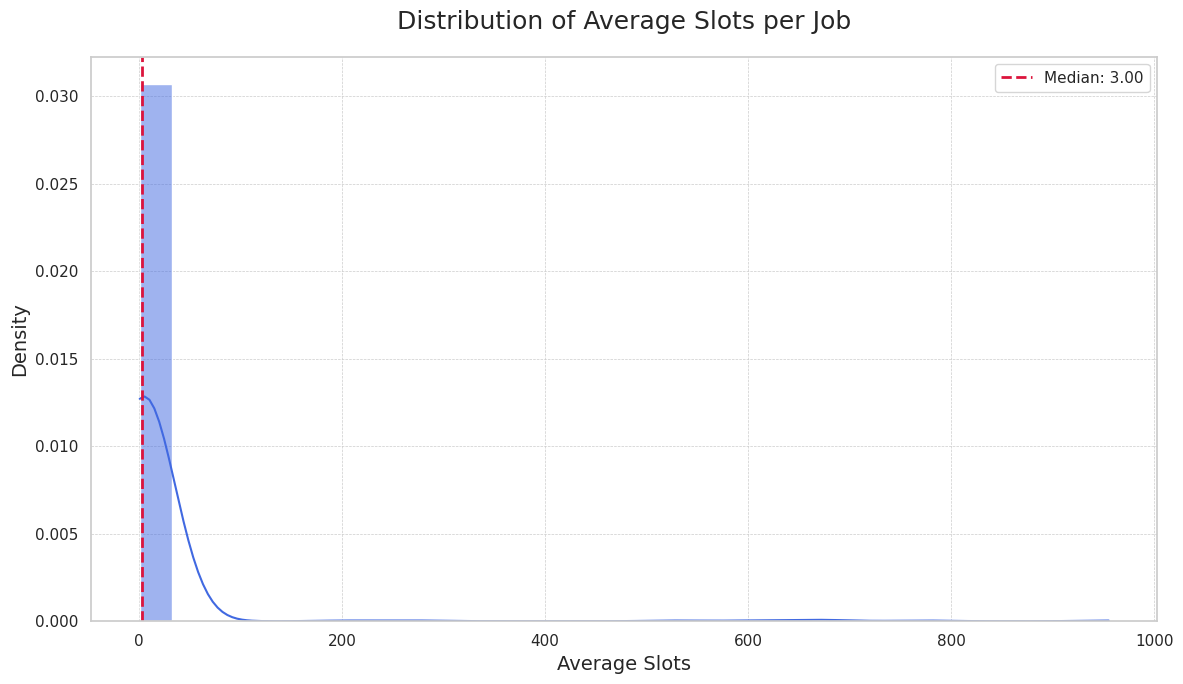

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove any null values that might have resulted from zero-duration jobs
top_queries.dropna(subset=['average_slots'], inplace=True)

# --- Plotting ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# Create a histogram and a Kernel Density Estimate (KDE) plot
sns.histplot(top_queries['average_slots'], kde=True, bins=30, color='royalblue', stat='density')

# --- Formatting ---
plt.title('Distribution of Average Slots per Job', fontsize=18, pad=20)
plt.xlabel('Average Slots', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a vertical line for the median
median_val = top_queries['average_slots'].median()
plt.axvline(median_val, color='crimson', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
plt.legend()

print(f"Plotting distribution for {len(top_queries)} jobs.")
print(top_queries['average_slots'].describe())

plt.tight_layout()
plt.show()

Slots timeline，10s time bucket for past 8 hours in the job period of 30 days.

槽使用时间序列

In [ ]:
%%bigquery slots_timeline

DECLARE start_time TIMESTAMP DEFAULT TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 8 HOUR);
DECLARE end_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP();

WITH JobPeriods AS (
  SELECT
    period_start,
    -- Approximate avg slots by assuming a 1-second (1000ms) interval duration.
    period_slot_ms / 1000.0 AS period_avg_slots
  FROM
    `region-us`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_PROJECT
  WHERE
    -- Use a wide creation_time filter for partition pruning, but a strict
    -- period_start filter to define the actual time window of the analysis.
    job_creation_time BETWEEN TIMESTAMP_SUB(start_time, INTERVAL 30 DAY) AND end_time
    AND period_start BETWEEN start_time AND end_time
    AND period_slot_ms > 0
)
SELECT
  -- Create 10-second time buckets for the X-axis
  TIMESTAMP_SECONDS(10 * DIV(UNIX_SECONDS(period_start), 10)) AS time_bucket,
  -- Sum the slots from all concurrent jobs within this 10-second bucket
  SUM(period_avg_slots) AS total_concurrent_slots
FROM
  JobPeriods
GROUP BY
  time_bucket
ORDER BY
  time_bucket;

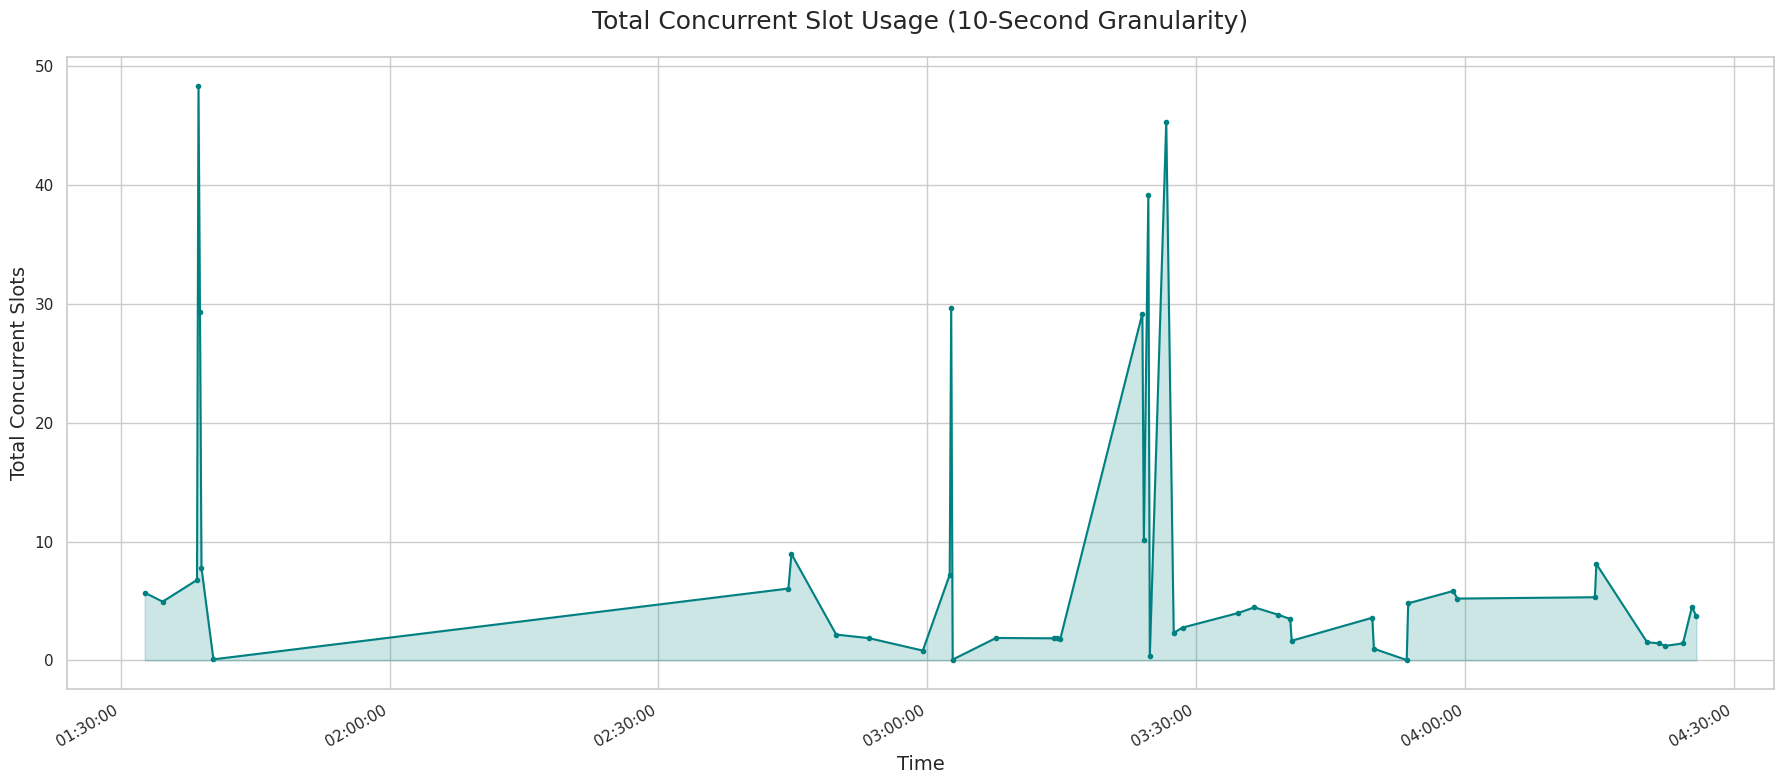

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

slots_timeline['time_bucket'] = pd.to_datetime(slots_timeline['time_bucket'])

# --- Plotting ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 8))

# Create a line plot of total slots over time
plt.plot(slots_timeline['time_bucket'], slots_timeline['total_concurrent_slots'], marker='.', linestyle='-', color='teal')

# --- Formatting ---
plt.title('Total Concurrent Slot Usage (10-Second Granularity)', fontsize=18, pad=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Concurrent Slots', fontsize=14)

# Format the x-axis to display time clearly
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Fill the area under the line for better visualization
plt.fill_between(slots_timeline['time_bucket'], slots_timeline['total_concurrent_slots'], alpha=0.2, color='teal')
plt.grid(True)
plt.tight_layout()
plt.show()

You can use [administrative resource charts](https://cloud.google.com/bigquery/docs/admin-resource-charts) to monitor your organization's health, slot usage, and BigQuery jobs performance over time. The following example queries the INFORMATION_SCHEMA.JOBS_TIMELINE view for a slot usage timeline at one-hour intervals, similar to the information that is available in administrative resource charts.

In [ ]:
%%bigquery

DECLARE end_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP();
DECLARE start_time TIMESTAMP DEFAULT TIMESTAMP_SUB(end_time, INTERVAL 30 DAY);

WITH
  snapshot_data AS (
  SELECT
    UNIX_MILLIS(period_start) AS period_start,
    IFNULL(SUM(period_slot_ms), 0) AS period_slot_ms,
    DIV(UNIX_MILLIS(period_start), 3600000 * 1) * 3600000 * 1 AS time_ms
  FROM (
    SELECT
      *
    FROM
      `du-hast-mich.region-US`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_PROJECT
    WHERE
      ((job_creation_time >= TIMESTAMP_SUB(start_time, INTERVAL 1200 MINUTE)
          AND job_creation_time < TIMESTAMP(end_time))
        AND period_start >= TIMESTAMP(start_time)
        AND period_start < TIMESTAMP(end_time))
      AND (statement_type != "SCRIPT"
        OR statement_type IS NULL)
      AND REGEXP_CONTAINS(reservation_id, "^du-hast-mich:") )
  GROUP BY
    period_start,
    time_ms ),
  converted_percentiles_data AS (
  SELECT
    time_ms,
    100 - CAST(SAFE_DIVIDE(3600000 * 1 * 1 / 1000, COUNT(*)) AS INT64) AS converted_percentiles,
  FROM
    snapshot_data
  GROUP BY
    time_ms ),
  data_by_time AS (
  SELECT
    time_ms,
  IF
    (converted_percentiles <= 0, 0, APPROX_QUANTILES(period_slot_ms, 100)[SAFE_OFFSET(converted_percentiles)] / 1000) AS p99_slots,
    SUM(period_slot_ms) / (3600000 * 1) AS avg_slots
  FROM
    snapshot_data
  JOIN
    converted_percentiles_data AS c
  USING
    (time_ms)
  GROUP BY
    time_ms,
    converted_percentiles )
SELECT
  time_ms,
  TIMESTAMP_MILLIS(time_ms) AS time_stamp,
  IFNULL(avg_slots, 0) AS avg_slots,
  IFNULL(p99_slots, 0) AS p99_slots,
FROM (
  SELECT
    time_ms * 3600000 * 1 AS time_ms
  FROM
    UNNEST(GENERATE_ARRAY(DIV(UNIX_MILLIS(start_time), 3600000 * 1), DIV(UNIX_MILLIS(end_time), 3600000 * 1) - 1, 1)) AS time_ms )
LEFT JOIN
  data_by_time
USING
  (time_ms)
ORDER BY
  time_ms DESC;

Check slot contention

In [ ]:
%%bigquery

SELECT
    job_id,
    SUM(period_slot_ms) / (1000 * 60 * 60) as slot_hours,
    MAX(period_slot_ms) as max_slot_ms_in_period
FROM
    `region-us`.INFORMATION_SCHEMA.JOBS_TIMELINE_BY_PROJECT
WHERE
    job_creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 7 DAY) AND CURRENT_TIMESTAMP()
GROUP BY
    job_id
HAVING
    max_slot_ms_in_period > 2000
ORDER BY
    max_slot_ms_in_period DESC;

Predict future usage

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL bq_usage.slot_forecasting
OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='usage_date',
  TIME_SERIES_DATA_COL='total_slot_hours'
) AS
SELECT
  DATE(creation_time) AS usage_date,
  SUM(total_slot_ms) / (1000 * 60 * 60) AS total_slot_hours
FROM
  `region-us`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
WHERE
  creation_time BETWEEN TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL 365 DAY) AND CURRENT_TIMESTAMP()
  AND total_slot_ms > 0
GROUP BY
  usage_date;



In [ ]:
%%bigquery

-- Now, use the trained model to forecast the next 30 days
SELECT
  *
FROM
  ML.FORECAST(MODEL bq_usage.slot_forecasting,
              STRUCT(30 AS horizon, 0.8 AS confidence_level));

Query is running:   0%|          |

Downloading:   0%|          |

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2025-07-10 00:00:00+00:00,0.076373,0.039186,0.8,0.026125,0.126620,0.026125,0.126620
1,2025-07-11 00:00:00+00:00,0.081983,0.063133,0.8,0.001029,0.162937,0.001029,0.162937
2,2025-07-12 00:00:00+00:00,0.104593,0.080224,0.8,0.001722,0.207464,0.001722,0.207464
3,2025-07-13 00:00:00+00:00,0.049314,0.094267,0.8,-0.071563,0.170191,-0.071563,0.170191
4,2025-07-14 00:00:00+00:00,0.006250,0.106473,0.8,-0.130278,0.142778,-0.130278,0.142778
5,2025-07-15 00:00:00+00:00,0.019487,0.117416,0.8,-0.131075,0.170048,-0.131075,0.170048
6,2025-07-16 00:00:00+00:00,0.039909,0.127424,0.8,-0.123485,0.203302,-0.123485,0.203302
7,2025-07-17 00:00:00+00:00,0.077488,0.136701,0.8,-0.097801,0.252778,-0.097801,0.252778
8,2025-07-18 00:00:00+00:00,0.083047,0.145387,0.8,-0.103380,0.269474,-0.103380,0.269474
9,2025-07-19 00:00:00+00:00,0.106612,0.153582,0.8,-0.090324,0.303548,-0.090324,0.303548
